In [1]:
%cd ..

/home/ec2-user/uclresearchanalysis


In [2]:
%matplotlib inline
import builtins
builtins.uclresearch_topic = 'GIVENCHY' #0 -- Finished
# builtins.uclresearch_topic = 'HAWKING' #0 -- Finished
# builtins.uclresearch_topic = 'NYC' # 88001
# builtins.uclresearch_topic = 'FLORIDA' # 448387
from configuration import config
from configuration.config import load_ml_data
import xgboost as xgb
from sklearn.feature_selection import SelectKBest
from sklearn.feature_selection import chi2
from sklearn.linear_model import LogisticRegression,LinearRegression
from sklearn.ensemble import GradientBoostingClassifier,RandomForestClassifier
from sklearn.naive_bayes import GaussianNB
from sklearn.model_selection import *
from sklearn.metrics import *
from sklearn import svm
from pandas import *
import pandas as pd
from pprint import pprint
import sys
import numpy as np
import matplotlib.pyplot as plt

('Reading config file from location: '
 '/home/ec2-user/uclresearchanalysis/configuration/env.properties')
{'calculate': {'analysis': True,
               'friends': True,
               'network': True,
               'uniquetweets': True,
               'uniqueusers': True},
 'data': {'dates': ['2018-03-11', '2018-03-12', '2018-03-13'],
          'eventname': "Givenchy's Death",
          'phrases': ['givenchy%20death', 'givenchy%20passed%20away'],
          'starttime': 'Mar 12 08:20:00 -0500 2018'},
 'path': {'cwd': '/home/ec2-user/uclresearchanalysis/data/givenchy',
          'ml': '/home/ec2-user/uclresearchanalysis/data/givenchy/pickle',
          'networkx': {'all': '/home/ec2-user/uclresearchanalysis/data/givenchy/pickle/networkx_all.dat',
                       'friends': '/home/ec2-user/uclresearchanalysis/data/givenchy/pickle/networkx_friends.dat',
                       'potential': '/home/ec2-user/uclresearchanalysis/data/givenchy/pickle/networkx_potential.dat'},
        

In [3]:
# Parameters
interval = 30

# 1. Prepare
def prepare_data(interval):
    df = load_ml_data(interval)
    df = df.reset_index(drop=True)
    
    # Converting all type to float, to prepare for feature selection
    df = df.astype('float')
    # Reset index, with drop equals to true to avoid setting old index as a new column
    df = df.reset_index(drop=True)
    # Visualize distribution
    print('[Original] data counts, with uninfected (0): {}, infected (1): {}'.format(
        df['label'].value_counts()[0],
        df['label'].value_counts()[1]
    ))
    df.groupby(['TwM_tCurrent','label']).size().unstack(fill_value=0).plot.bar(title='Original Data Distribution')
    
    columns = list(df.columns)
    columns.remove('label')
    
    X = df[columns]
    y = df[['label']]
    return df, X, y


Loading data file from path /home/ec2-user/uclresearchanalysis/data/givenchy/pickle/30_data.dat
'Loaded 226984 entires'
[Original] data counts, with uninfected (0): 45869, infected (1): 181115


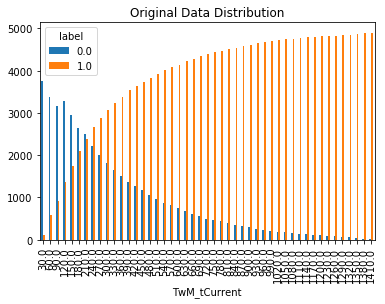

In [4]:
# 1. Prepare
df, X, y = prepare_data(interval)

In [5]:
len(X.columns)

68

In [6]:
def train(df, X, y, model, n_folds, is_xgb):
    # 2. N Fold Split
    # Stratified K-Folds cross-validator
    # Provides train/test indices to split data in train/test sets. 
    # This cross-validation object is a variation of KFold that returns stratified folds. 
    # The folds are made by preserving the percentage of samples for each class.
    skf = StratifiedKFold(n_splits=n_folds, shuffle=True)
    
    corrDataframe = pd.DataFrame()    
    mse = []
    acc = []
    roc = []
    F1 = []
    auc = []
    auc_t = []
    acc_t = []
    fold_count = 0
    t_current = 210
#     number_of_features = len(X.columns)
    number_of_features = 60

    print("Start cross validation")
    for train, test in skf.split(X, y):
        print("===Processing fold %s===" % fold_count)
        train_fold = df.loc[train]
        test_fold = df.loc[test]

        # 3. Rebalance (Up-sampling)
        diff = sum(train_fold.label == 1) - sum(train_fold.label == 0)
        append_indices = np.random.choice(train_fold[train_fold.label == 0].index, diff, replace=True)
        new_sample = train_fold.loc[append_indices,:]
        train_fold = pd.concat([train_fold, new_sample])
        train_fold = train_fold.reset_index(drop=True)
        print('[Up-sampling] data counts, with uninfected (0): {}, infected (1): {}'.format(
            train_fold['label'].value_counts()[0],
            train_fold['label'].value_counts()[1],
        ))
        
        # 4. Feature Selection
        corr = train_fold.corr()['label'][train_fold.corr()['label'] < 1].abs()
        corr = corr.sort_values(ascending=False)
        corrDataframe = corrDataframe.append(pd.DataFrame(corr.rename('cv{}'.format(fold_count))).T)

        features = corr.index[range(number_of_features)].values
#         train_fold_input  = SelectKBest(chi2, k=50).fit_transform(train_fold[X.columns], train_fold['label'])

        train_fold_input = train_fold[features]
        train_fold_output = train_fold['label']
        
        # 5. Training
        # Fit logistic regression
        if is_xgb:
            xgtrain = xgb.DMatrix(train_fold_input.values, train_fold_output.values)
#             evallist = [(xgtest, 'eval'), (xgtrain, 'train')]
            evallist = [(xgtrain, 'train')]
            bst = xgb.train(model, xgtrain, 50, evallist)
        else:
            model.fit(train_fold_input, train_fold_output)

        # 6. Testing
        # Check MSE on test set
        test_fold_t = test_fold[test_fold.TwM_tCurrent == t_current]
        if is_xgb:
            xgtest = xgb.DMatrix(test_fold[features].values)
            xgtest_t = xgb.DMatrix(test_fold_t[features].values)
            pred = bst.predict(xgtest)
            pred_t = bst.predict(xgtest_t)
        else:
            pred = model.predict(test_fold[features])
            pred_t = model.predict(test_fold_t[features])
        mse.append(mean_squared_error(test_fold.label, pred))
        roc.append(roc_auc_score(test_fold.label, pred))
        auc_t.append(roc_auc_score(test_fold_t.label, pred_t))

        acc.append(accuracy_score(test_fold.label, (pred>0.5).astype(int)))
        acc_t.append(accuracy_score(test_fold_t.label, (pred_t>0.5).astype(int)))
        F1.append(f1_score(test_fold.label,(pred>0.5).astype(int)))
        cm = confusion_matrix(test_fold.label, (pred>0.5).astype(int))
        print(cm)

        # Done with the fold
        fold_count += 1
    print("Finished cross validation")
    print("MSE: {} ".format(DataFrame(mse).mean()))
    print("ACC: {} ".format(DataFrame(acc).mean()))
    print("AUC: {} ".format(DataFrame(roc).mean()))
#     print("F1: {} ".format(DataFrame(F1).mean()))
    print("ACC for t at {}: {} ".format(t_current, DataFrame(acc_t).mean()))
    corrDataframe = corrDataframe.T
    corrDataframe['average corr'] = corrDataframe.mean(numeric_only=True, axis=1)
    print(corrDataframe.sort_values(by=['average corr'], ascending=False).to_string())
    if is_xgb:
        return bst
    return model

In [ ]:
#xgboost
param = {'max_depth': 12, 'eta': 1, 'silent': 1, 'objective': 'binary:logistic'}
param['nthread'] = 12
param['eval_metric'] = ['auc']

xgb_model = train(df, X, y, param, 10, 1)

Start cross validation
===Processing fold 0===
[Up-sampling] data counts, with uninfected (0): 163003, infected (1): 163003
[0]	train-auc:0.999907
[1]	train-auc:0.999999
[2]	train-auc:0.999998
[3]	train-auc:1
[4]	train-auc:1
[5]	train-auc:1
[6]	train-auc:1
[7]	train-auc:1
[8]	train-auc:1
[9]	train-auc:1
[10]	train-auc:1
[11]	train-auc:1
[12]	train-auc:1
[13]	train-auc:1
[14]	train-auc:1
[15]	train-auc:1
[16]	train-auc:1
[17]	train-auc:1
[18]	train-auc:1
[19]	train-auc:1
[20]	train-auc:1
[21]	train-auc:1
[22]	train-auc:1
[23]	train-auc:1
[24]	train-auc:1
[25]	train-auc:1
[26]	train-auc:1
[27]	train-auc:1
[28]	train-auc:1
[29]	train-auc:1
[30]	train-auc:1
[31]	train-auc:1
[32]	train-auc:1
[33]	train-auc:1
[34]	train-auc:1
[35]	train-auc:1
[36]	train-auc:1
[37]	train-auc:1
[38]	train-auc:1
[39]	train-auc:1
[40]	train-auc:1
[41]	train-auc:1
[42]	train-auc:1
[43]	train-auc:1
[44]	train-auc:1
[45]	train-auc:1
[46]	train-auc:1
[47]	train-auc:1
[48]	train-auc:1
[49]	train-auc:1
[[ 4584     3]


/home/ec2-user/miniconda3/lib/python3.6/site-packages/pandas/core/frame.py:6211: FutureWarning: Sorting because non-concatenation axis is not aligned. A future version
of pandas will change to not sort by default.

To accept the future behavior, pass 'sort=False'.

To retain the current behavior and silence the warning, pass 'sort=True'.

  sort=sort)


[0]	train-auc:0.999895
[1]	train-auc:0.999975
[2]	train-auc:1
[3]	train-auc:1
[4]	train-auc:1
[5]	train-auc:1
[6]	train-auc:1
[7]	train-auc:1
[8]	train-auc:1
[9]	train-auc:1
[10]	train-auc:1
[11]	train-auc:1
[12]	train-auc:1
[13]	train-auc:1
[14]	train-auc:1
[15]	train-auc:1
[16]	train-auc:1
[17]	train-auc:1
[18]	train-auc:1
[19]	train-auc:1
[20]	train-auc:1
[21]	train-auc:1
[22]	train-auc:1
[23]	train-auc:1
[24]	train-auc:1
[25]	train-auc:1
[26]	train-auc:1
[27]	train-auc:1
[28]	train-auc:1
[29]	train-auc:1
[30]	train-auc:1
[31]	train-auc:1
[32]	train-auc:1
[33]	train-auc:1
[34]	train-auc:1
[35]	train-auc:1
[36]	train-auc:1
[37]	train-auc:1
[38]	train-auc:1
[39]	train-auc:1
[40]	train-auc:1
[41]	train-auc:1
[42]	train-auc:1
[43]	train-auc:1
[44]	train-auc:1
[45]	train-auc:1
[46]	train-auc:1
[47]	train-auc:1
[48]	train-auc:1
[49]	train-auc:1
[[ 4586     1]
 [    6 18106]]
===Processing fold 2===
[Up-sampling] data counts, with uninfected (0): 163003, infected (1): 163003
[0]	train-auc:

In [6]:
# Naive Bayes
train(df, X, y, GaussianNB(), 10)

Start cross validation
===Processing fold 0===
[Up-sampling] data counts, with uninfected (0): 163003, infected (1): 163003
[[ 3302  1285]
 [ 3397 14715]]
===Processing fold 1===
[Up-sampling] data counts, with uninfected (0): 163003, infected (1): 163003


/home/ec2-user/miniconda3/lib/python3.6/site-packages/pandas/core/frame.py:6211: FutureWarning: Sorting because non-concatenation axis is not aligned. A future version
of pandas will change to not sort by default.

To accept the future behavior, pass 'sort=False'.

To retain the current behavior and silence the warning, pass 'sort=True'.

  sort=sort)


[[ 3394  1193]
 [ 3652 14460]]
===Processing fold 2===
[Up-sampling] data counts, with uninfected (0): 163003, infected (1): 163003
[[ 3430  1157]
 [ 3577 14535]]
===Processing fold 3===
[Up-sampling] data counts, with uninfected (0): 163003, infected (1): 163003
[[ 3447  1140]
 [ 3669 14443]]
===Processing fold 4===
[Up-sampling] data counts, with uninfected (0): 163003, infected (1): 163003
[[ 3349  1238]
 [ 3594 14518]]
===Processing fold 5===
[Up-sampling] data counts, with uninfected (0): 163004, infected (1): 163004
[[ 3379  1208]
 [ 3605 14506]]
===Processing fold 6===
[Up-sampling] data counts, with uninfected (0): 163004, infected (1): 163004
[[ 3323  1264]
 [ 3478 14633]]
===Processing fold 7===
[Up-sampling] data counts, with uninfected (0): 163004, infected (1): 163004
[[ 3390  1197]
 [ 3662 14449]]
===Processing fold 8===
[Up-sampling] data counts, with uninfected (0): 163004, infected (1): 163004
[[ 3480  1107]
 [ 3630 14481]]
===Processing fold 9===
[Up-sampling] data co

In [7]:
# Logistic Regression
train(df, X, y, LogisticRegression(), 10)


Start cross validation
===Processing fold 0===
[Up-sampling] data counts, with uninfected (0): 163003, infected (1): 163003
[[ 3736   851]
 [ 4340 13772]]
===Processing fold 1===
[Up-sampling] data counts, with uninfected (0): 163003, infected (1): 163003


/home/ec2-user/miniconda3/lib/python3.6/site-packages/pandas/core/frame.py:6211: FutureWarning: Sorting because non-concatenation axis is not aligned. A future version
of pandas will change to not sort by default.

To accept the future behavior, pass 'sort=False'.

To retain the current behavior and silence the warning, pass 'sort=True'.

  sort=sort)


[[ 3719   868]
 [ 4340 13772]]
===Processing fold 2===
[Up-sampling] data counts, with uninfected (0): 163003, infected (1): 163003
[[ 3744   843]
 [ 4321 13791]]
===Processing fold 3===
[Up-sampling] data counts, with uninfected (0): 163003, infected (1): 163003
[[ 3687   900]
 [ 4406 13706]]
===Processing fold 4===
[Up-sampling] data counts, with uninfected (0): 163003, infected (1): 163003
[[ 3694   893]
 [ 4432 13680]]
===Processing fold 5===
[Up-sampling] data counts, with uninfected (0): 163004, infected (1): 163004
[[ 3739   848]
 [ 4457 13654]]
===Processing fold 6===
[Up-sampling] data counts, with uninfected (0): 163004, infected (1): 163004
[[ 3736   851]
 [ 4390 13721]]
===Processing fold 7===
[Up-sampling] data counts, with uninfected (0): 163004, infected (1): 163004
[[ 3752   835]
 [ 4361 13750]]
===Processing fold 8===
[Up-sampling] data counts, with uninfected (0): 163004, infected (1): 163004
[[ 3696   891]
 [ 4367 13744]]
===Processing fold 9===
[Up-sampling] data co

In [9]:
# Random Forest 10 folds
rf_10 = train(df, X, y, RandomForestClassifier(n_estimators= 100,min_samples_split=2,
                                  min_samples_leaf=1,random_state=10), 10)

Start cross validation
===Processing fold 0===
[Up-sampling] data counts, with uninfected (0): 163003, infected (1): 163003
[[ 4139   448]
 [  774 17338]]
===Processing fold 1===
[Up-sampling] data counts, with uninfected (0): 163003, infected (1): 163003


/home/ec2-user/miniconda3/lib/python3.6/site-packages/pandas/core/frame.py:6211: FutureWarning: Sorting because non-concatenation axis is not aligned. A future version
of pandas will change to not sort by default.

To accept the future behavior, pass 'sort=False'.

To retain the current behavior and silence the warning, pass 'sort=True'.

  sort=sort)


[[ 4155   432]
 [  683 17429]]
===Processing fold 2===
[Up-sampling] data counts, with uninfected (0): 163003, infected (1): 163003


/home/ec2-user/miniconda3/lib/python3.6/site-packages/pandas/core/frame.py:6211: FutureWarning: Sorting because non-concatenation axis is not aligned. A future version
of pandas will change to not sort by default.

To accept the future behavior, pass 'sort=False'.

To retain the current behavior and silence the warning, pass 'sort=True'.

  sort=sort)


[[ 4084   503]
 [  732 17380]]
===Processing fold 3===
[Up-sampling] data counts, with uninfected (0): 163003, infected (1): 163003


/home/ec2-user/miniconda3/lib/python3.6/site-packages/pandas/core/frame.py:6211: FutureWarning: Sorting because non-concatenation axis is not aligned. A future version
of pandas will change to not sort by default.

To accept the future behavior, pass 'sort=False'.

To retain the current behavior and silence the warning, pass 'sort=True'.

  sort=sort)


[[ 4151   436]
 [  705 17407]]
===Processing fold 4===
[Up-sampling] data counts, with uninfected (0): 163003, infected (1): 163003


/home/ec2-user/miniconda3/lib/python3.6/site-packages/pandas/core/frame.py:6211: FutureWarning: Sorting because non-concatenation axis is not aligned. A future version
of pandas will change to not sort by default.

To accept the future behavior, pass 'sort=False'.

To retain the current behavior and silence the warning, pass 'sort=True'.

  sort=sort)


[[ 4194   393]
 [  685 17427]]
===Processing fold 5===
[Up-sampling] data counts, with uninfected (0): 163004, infected (1): 163004


/home/ec2-user/miniconda3/lib/python3.6/site-packages/pandas/core/frame.py:6211: FutureWarning: Sorting because non-concatenation axis is not aligned. A future version
of pandas will change to not sort by default.

To accept the future behavior, pass 'sort=False'.

To retain the current behavior and silence the warning, pass 'sort=True'.

  sort=sort)


[[ 4231   356]
 [  754 17357]]
===Processing fold 6===
[Up-sampling] data counts, with uninfected (0): 163004, infected (1): 163004


/home/ec2-user/miniconda3/lib/python3.6/site-packages/pandas/core/frame.py:6211: FutureWarning: Sorting because non-concatenation axis is not aligned. A future version
of pandas will change to not sort by default.

To accept the future behavior, pass 'sort=False'.

To retain the current behavior and silence the warning, pass 'sort=True'.

  sort=sort)


[[ 4233   354]
 [  699 17412]]
===Processing fold 7===
[Up-sampling] data counts, with uninfected (0): 163004, infected (1): 163004


/home/ec2-user/miniconda3/lib/python3.6/site-packages/pandas/core/frame.py:6211: FutureWarning: Sorting because non-concatenation axis is not aligned. A future version
of pandas will change to not sort by default.

To accept the future behavior, pass 'sort=False'.

To retain the current behavior and silence the warning, pass 'sort=True'.

  sort=sort)


[[ 4109   478]
 [  755 17356]]
===Processing fold 8===
[Up-sampling] data counts, with uninfected (0): 163004, infected (1): 163004


/home/ec2-user/miniconda3/lib/python3.6/site-packages/pandas/core/frame.py:6211: FutureWarning: Sorting because non-concatenation axis is not aligned. A future version
of pandas will change to not sort by default.

To accept the future behavior, pass 'sort=False'.

To retain the current behavior and silence the warning, pass 'sort=True'.

  sort=sort)


[[ 4127   460]
 [  707 17404]]
===Processing fold 9===
[Up-sampling] data counts, with uninfected (0): 163004, infected (1): 163004


/home/ec2-user/miniconda3/lib/python3.6/site-packages/pandas/core/frame.py:6211: FutureWarning: Sorting because non-concatenation axis is not aligned. A future version
of pandas will change to not sort by default.

To accept the future behavior, pass 'sort=False'.

To retain the current behavior and silence the warning, pass 'sort=True'.

  sort=sort)


[[ 4116   470]
 [  769 17342]]
Finished cross validation
MSE: 0    0.051074
dtype: float64 
ACC: 0    0.948926
dtype: float64 
AUC: 0    0.932749
dtype: float64 
F1: 0    0.967735
dtype: float64 
ACC for t at 210: 0    0.829385
dtype: float64 
                                                 cv0       cv1       cv2       cv3       cv4       cv5       cv6       cv7       cv8       cv9  average corr
TwM_t0                                      0.624206  0.624784  0.624643  0.624082  0.623555  0.625452  0.623880  0.622749  0.622564  0.624420      0.624033
TwM_tCurrent                                0.622394  0.622905  0.623195  0.622403  0.621827  0.623709  0.622193  0.621381  0.621039  0.622872      0.622392
Stat_average_t                              0.609490  0.609845  0.609748  0.608857  0.608675  0.610377  0.609355  0.608153  0.607523  0.609129      0.609115
TwM_t-1                                     0.537804  0.538096  0.537872  0.536867  0.537079  0.538327  0.537890  0.536635  0.53

In [12]:
rf_2 = train(df, X, y, RandomForestClassifier(n_estimators= 100,min_samples_split=2,
                                  min_samples_leaf=1,random_state=10), 2)

Start cross validation
===Processing fold 0===
[Up-sampling] data counts, with uninfected (0): 90557, infected (1): 90557
[[20510  2425]
 [ 3544 87014]]
===Processing fold 1===
[Up-sampling] data counts, with uninfected (0): 90558, infected (1): 90558


/home/ec2-user/miniconda3/lib/python3.6/site-packages/pandas/core/frame.py:6211: FutureWarning: Sorting because non-concatenation axis is not aligned. A future version
of pandas will change to not sort by default.

To accept the future behavior, pass 'sort=False'.

To retain the current behavior and silence the warning, pass 'sort=True'.

  sort=sort)


[[19810  3124]
 [ 4317 86240]]
Finished cross validation
MSE: 0    0.059079
dtype: float64 
ACC: 0    0.940921
dtype: float64 
AUC: 0    0.917811
dtype: float64 
F1: 0    0.962741
dtype: float64 
ACC for t at 210: 0    0.792842
dtype: float64 
                                                 cv0       cv1  average corr
TwM_t0                                      0.624205  0.625142      0.624673
TwM_tCurrent                                0.622063  0.624017      0.623040
Stat_average_t                              0.609606  0.610090      0.609848
TwM_t-1                                     0.537956  0.537945      0.537950
Nw_outDegreeCentrality-1                    0.204178  0.208046      0.206112
Nw_degreeCentrality-1                       0.199932  0.203934      0.201933
Stat_min_kOut                               0.197963  0.198967      0.198465
Nw_betweennessCentrality-1                  0.184304  0.188412      0.186358
Stat_average_kOut                           0.171815  0.173698 

In [18]:
importances=rf_10.feature_importances_

In [17]:
rf_2.feature_importances_

array([0.11437357, 0.1255083 , 0.0985373 , 0.07220299, 0.0081229 ,
       0.00850846, 0.01203892, 0.00558541, 0.0096856 , 0.00433541,
       0.00625913, 0.00650834, 0.01107941, 0.0057833 , 0.01003228,
       0.00530494, 0.00878706, 0.01013125, 0.00537493, 0.0149048 ,
       0.00829611, 0.00511146, 0.00151205, 0.00659626, 0.00151777,
       0.0016192 , 0.00156393, 0.00160628, 0.00146474, 0.0018072 ,
       0.00161766, 0.00170088, 0.00153224, 0.0015575 , 0.00137469,
       0.00152368, 0.00154734, 0.00801275, 0.05387167, 0.00627333,
       0.00924356, 0.05388909, 0.00178274, 0.00781696, 0.00577942,
       0.02387744, 0.00138614, 0.01449663, 0.00879068, 0.00220879,
       0.00593977, 0.00578732, 0.00865982, 0.05753796, 0.00972171,
       0.00162264, 0.05791569, 0.0065575 , 0.05501204, 0.00880309])

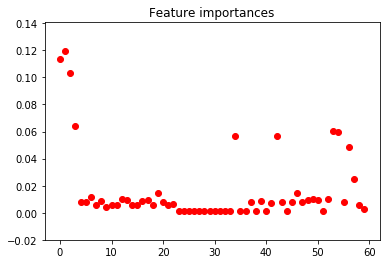

In [30]:
plt.figure()
plt.title("Feature importances")
plt.scatter(range(0,60), importances,  color="r")
# plt.xticks(range(X.shape[1]), indices)
# plt.xlim([-1, X.shape[1]])
plt.show()

In [25]:
# GBDT
train(df, X, y, GradientBoostingClassifier(n_estimators=150, min_samples_split=30,
                                  min_samples_leaf=2,max_depth=12,max_features='sqrt', subsample=0.8,random_state=10), 10)

TypeError: train() missing 1 required positional argument: 'is_xgb'